<a href="https://colab.research.google.com/github/UsmanNetwork/Goalitics/blob/main/GOALITICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Load the dataset (adjust path if needed, e.g., '/content/epl_final.csv')
DH = pd.read_csv('epl_final.csv')

# Convert MatchDate to datetime object and sort the data chronologically (CRITICAL)
DH['MatchDate'] = pd.to_datetime(DH['MatchDate'])
DH = DH.sort_values(by='MatchDate').reset_index(drop=True)

print("Data Loaded and Sorted. Head of DataFrame:")
print(DH[['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult']].head())

Data Loaded and Sorted. Head of DataFrame:
   MatchDate  HomeTeam       AwayTeam FullTimeResult
0 2000-08-19  Charlton       Man City              H
1 2000-08-19   Chelsea       West Ham              H
2 2000-08-19  Coventry  Middlesbrough              A
3 2000-08-19     Derby    Southampton              D
4 2000-08-19     Leeds        Everton              H


In [2]:
def calculate_optimal_form_score(df_team, window=5):
    """
    Implements the A* logic: calculates the rolling cumulative cost (g(n))
    over the window for a single team.
    """

    # 1. Determine the outcome cost (g(n)) for the team being analyzed
    def get_team_cost(row):
        result = row['FullTimeResult']
        role = row['Role']

        # Win (Cost 0)
        if (role == 'H' and result == 'H') or (role == 'A' and result == 'A'):
            return 0
        # Draw (Cost 1)
        elif result == 'D':
            return 1
        # Loss (Cost 3)
        else:
            return 3

    # Apply the cost function to create the g(n) column
    df_team['Cost'] = df_team.apply(get_team_cost, axis=1)

    # 2. Calculate the rolling sum (cumulative cost) and shift by 1 (PREVENTS DATA LEAKAGE)
    df_team['Optimal_Form_Score'] = df_team['Cost'].rolling(
        window=window, min_periods=1
    ).sum().shift(1).fillna(0) # Fill initial NaNs with 0 (assuming perfect form before history)

    return df_team[['MatchDate', 'Team', 'Optimal_Form_Score']]

# --- Prepare Data for Sequential Group-wise Application ---

# 1. Prepare Home Matches: Rename and add 'Role'
home_matches = DH[['MatchDate', 'HomeTeam', 'FullTimeResult']].copy()
home_matches.rename(columns={'HomeTeam': 'Team'}, inplace=True)
home_matches['Role'] = 'H'

# 2. Prepare Away Matches: Rename and add 'Role'
away_matches = DH[['MatchDate', 'AwayTeam', 'FullTimeResult']].copy()
away_matches.rename(columns={'AwayTeam': 'Team'}, inplace=True)
away_matches['Role'] = 'A'

# 3. Combine and sort
all_matches = pd.concat([home_matches, away_matches]).sort_values(by='MatchDate').reset_index(drop=True)

# 4. Apply the A* logic to each team group
form_scores = all_matches.groupby('Team', group_keys=False).apply(
    calculate_optimal_form_score, window=5
)

# Prepare the scores for merging in the next step
form_scores.rename(columns={'Team': 'TeamName'}, inplace=True)
form_scores['Form_Check'] = form_scores['MatchDate'].astype(str) + form_scores['TeamName']

print("Optimal Form Scores calculated. Sample (First 10 rows):")
print(form_scores.head(10))

Optimal Form Scores calculated. Sample (First 10 rows):
   MatchDate       TeamName  Optimal_Form_Score               Form_Check
0 2000-08-19       Charlton                 0.0       2000-08-19Charlton
1 2000-08-19    Southampton                 0.0    2000-08-19Southampton
2 2000-08-19        Everton                 0.0        2000-08-19Everton
3 2000-08-19    Aston Villa                 0.0    2000-08-19Aston Villa
4 2000-08-19       Bradford                 0.0       2000-08-19Bradford
5 2000-08-19        Arsenal                 0.0        2000-08-19Arsenal
6 2000-08-19        Ipswich                 0.0        2000-08-19Ipswich
7 2000-08-19       Man City                 0.0       2000-08-19Man City
8 2000-08-19  Middlesbrough                 0.0  2000-08-19Middlesbrough
9 2000-08-19       West Ham                 0.0       2000-08-19West Ham


/tmp/ipython-input-3310201702.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  form_scores = all_matches.groupby('Team', group_keys=False).apply(


In [3]:
# Prepare the main DataFrame for merging
DH['Home_Check'] = DH['MatchDate'].astype(str) + DH['HomeTeam']
DH['Away_Check'] = DH['MatchDate'].astype(str) + DH['AwayTeam']

# 1. Merge the Optimal Form Score for the Home Team
DH = pd.merge(DH, form_scores[['Form_Check', 'Optimal_Form_Score']],
              left_on='Home_Check', right_on='Form_Check',
              how='left')
DH.rename(columns={'Optimal_Form_Score': 'Home_Optimal_Form_Score'}, inplace=True)
DH.drop(columns=['Form_Check', 'Home_Check'], inplace=True)

# 2. Merge the Optimal Form Score for the Away Team
DH = pd.merge(DH, form_scores[['Form_Check', 'Optimal_Form_Score']],
              left_on='Away_Check', right_on='Form_Check',
              how='left')
DH.rename(columns={'Optimal_Form_Score': 'Away_Optimal_Form_Score'}, inplace=True)
DH.drop(columns=['Form_Check', 'Away_Check'], inplace=True)


# 3. Create the crucial predictive feature: Form Differential
# (Away Score - Home Score). Positive value favors the Home team.
DH['Optimal_Form_Differential'] = DH['Away_Optimal_Form_Score'] - DH['Home_Optimal_Form_Score']

# Display the final integrated features
print("\n--- Final Integrated Feature DataFrame Head (Deliverable 2 Working Example Complete) ---")
print(DH[['MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeResult',
          'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score',
          'Optimal_Form_Differential']].head(10))

# Save the updated DataFrame for Deliverable 3
DH.to_csv('epl_with_agent_features.csv', index=False)


--- Final Integrated Feature DataFrame Head (Deliverable 2 Working Example Complete) ---
   MatchDate    HomeTeam       AwayTeam FullTimeResult  \
0 2000-08-19    Charlton       Man City              H   
1 2000-08-19     Chelsea       West Ham              H   
2 2000-08-19    Coventry  Middlesbrough              A   
3 2000-08-19       Derby    Southampton              D   
4 2000-08-19       Leeds        Everton              H   
5 2000-08-19   Leicester    Aston Villa              D   
6 2000-08-19   Liverpool       Bradford              H   
7 2000-08-19  Sunderland        Arsenal              H   
8 2000-08-19   Tottenham        Ipswich              H   
9 2000-08-20  Man United      Newcastle              H   

   Home_Optimal_Form_Score  Away_Optimal_Form_Score  Optimal_Form_Differential  
0                      0.0                      0.0                        0.0  
1                      0.0                      0.0                        0.0  
2                      0.0  

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# --- Classification Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# --- Regression Model ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

# Load the enriched dataset containing the A* Agent features
df = pd.read_csv('epl_with_agent_features.csv')

# --- 1. Target Encoding ---
# The target variable is 'FullTimeResult' (H, D, A). LabelEncoder maps these to 0, 1, 2.
le = LabelEncoder()
df['Target'] = le.fit_transform(df['FullTimeResult'])

# --- 2. Feature Selection ---
numerical_features = ['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                      'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                      'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
                      # Agent Features (Optimal Form Score)
                      'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score', 'Optimal_Form_Differential']
categorical_features = ['HomeTeam', 'AwayTeam']

X = df[numerical_features + categorical_features]
y = df['Target']

# --- 3. Time-Series Train-Test Split (80/20 split) ---
# CRITICAL: Splitting chronologically to prevent data leakage.
split_point = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# --- 4. Preprocessing Pipeline Definition ---
# Defines the transformation steps (scaling and encoding) applied to features.
preprocessor = ColumnTransformer(
    transformers=[
        # Apply standardization to numerical columns (e.g., Shots, Form Scores)
        ('num', StandardScaler(), numerical_features),
        # Apply one-hot encoding to team names (HomeTeam, AwayTeam)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. Baseline Model Training and Evaluation ---

class LinearRegressionClassifier(BaseEstimator, TransformerMixin):
    """
    Adapter class to use the Regression model (Linear Regression) for a classification task.
    Required by the project specification.
    """
    def __init__(self, **kwargs):
        self.model = LinearRegression(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        # Clip and round to force prediction into the 0, 1, 2 class labels
        return np.clip(np.round(y_pred), 0, 2).astype(int)

def train_and_evaluate_model(model, name, X_train, y_train, X_test, y_test, preprocessor):
    """Utility function to train a model within the pipeline and calculate all required metrics."""

    # Full pipeline includes preprocessing and the classifier
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    print(f"\n--- Training {name} ---")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics (Macro averaging used for multi-class H/D/A)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    roc_auc = 'N/A'
    try:
        # ROC-AUC uses probabilities (predict_proba)
        y_proba = pipeline.predict_proba(X_test)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    except AttributeError:
        pass

    metrics = {
        'Model': name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision (Macro)': f"{precision:.4f}",
        'Recall (Macro)': f"{recall:.4f}",
        'F1-Score (Macro)': f"{f1:.4f}",
        'ROC-AUC (Macro, OVR)': roc_auc if isinstance(roc_auc, str) else f"{roc_auc:.4f}"
    }
    return metrics

results = []

# --- 1. Logistic Regression (Linear Classification Baseline) ---
results.append(train_and_evaluate_model(
    model=LogisticRegression(max_iter=1000, random_state=42),
    name="Logistic Regression",
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor)
)

# --- 2. Random Forest Classifier (Non-linear Ensemble Baseline) ---
results.append(train_and_evaluate_model(
    model=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    name="Random Forest",
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor)
)

# --- 3. Adapted Linear Regression (Regression Model Baseline) ---
results.append(train_and_evaluate_model(
    model=LinearRegressionClassifier(),
    name="Adapted Linear Regression",
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, preprocessor=preprocessor)
)

results_df = pd.DataFrame(results)
print("\n\n--- Baseline Model Performance Metrics ---")
print(results_df)

results_df.to_csv('baseline_model_metrics.csv', index=False)


--- Training Logistic Regression ---

--- Training Random Forest ---

--- Training Adapted Linear Regression ---


--- Baseline Model Performance Metrics ---
                       Model Accuracy Precision (Macro) Recall (Macro)  \
0        Logistic Regression   0.5896            0.5357         0.5230   
1              Random Forest   0.5906            0.5143         0.5173   
2  Adapted Linear Regression   0.3966            0.6317         0.4521   

  F1-Score (Macro) ROC-AUC (Macro, OVR)  
0           0.5095               0.7295  
1           0.4943               0.7309  
2           0.3770                  N/A  


/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


/tmp/ipython-input-2649386322.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['ROC-AUC (Macro, OVR)'] = results_df['ROC-AUC (Macro, OVR)'].replace('N/A', np.nan).astype(float)


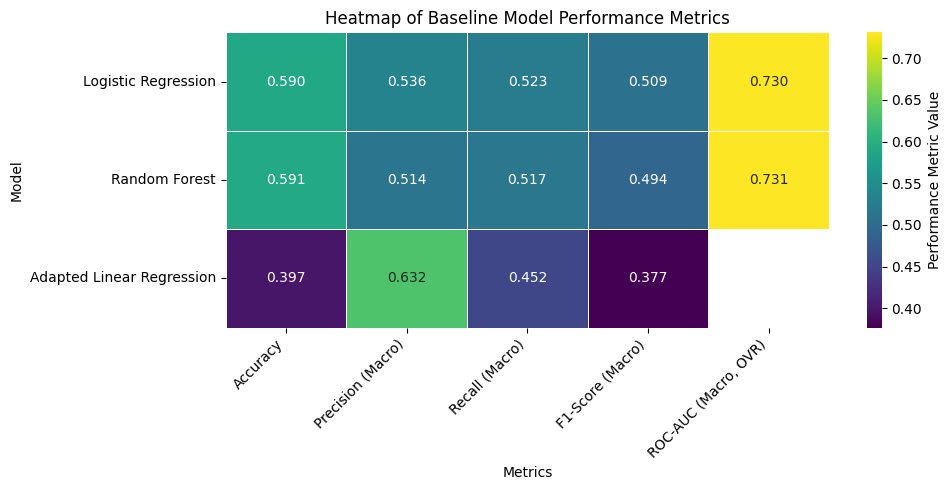

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data provided by the user
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Adapted Linear Regression'],
    'Accuracy': [0.5896, 0.5906, 0.3966],
    'Precision (Macro)': [0.5357, 0.5143, 0.6317],
    'Recall (Macro)': [0.5230, 0.5173, 0.4521],
    'F1-Score (Macro)': [0.5095, 0.4943, 0.3770],
    'ROC-AUC (Macro, OVR)': [0.7295, 0.7309, 'N/A']
}

results_df = pd.DataFrame(data)

# 1. Handle the 'N/A' entry for plotting
# Replace 'N/A' with NaN (Not a Number)
results_df['ROC-AUC (Macro, OVR)'] = results_df['ROC-AUC (Macro, OVR)'].replace('N/A', np.nan).astype(float)

# 2. Set 'Model' as the index for the heatmap
results_df = results_df.set_index('Model')

# 3. Create the heatmap
plt.figure(figsize=(10, 5))

# Use the 'viridis' colormap (darker color = higher value/better performance)
sns.heatmap(
    results_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    linewidths=.5,
    cbar_kws={'label': 'Performance Metric Value'}
)

plt.title('Heatmap of Baseline Model Performance Metrics')
plt.ylabel('Model')
plt.xlabel('Metrics')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig('baseline_heatmap.png')

In [6]:
from collections import Counter
print("before smote", Counter(y_train))

before smote Counter({2: 3487, 0: 2133, 1: 1884})


In [7]:
import pandas as pd
import numpy as np
# New imports for imbalanced learning and XGBoost
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin # Necessary for the custom LinearRegressionClassifier, but not for XGBoost

# --- Recreate Data and Preprocessor from Deliverable 3 ---

# Load the enriched dataset
df = pd.read_csv('epl_with_agent_features.csv')

# Target Encoding (H=2, D=1, A=0)
le = LabelEncoder()
df['Target'] = le.fit_transform(df['FullTimeResult'])

# Feature Selection
numerical_features = ['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                      'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                      'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
                      'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score', 'Optimal_Form_Differential']
categorical_features = ['HomeTeam', 'AwayTeam']

X = df[numerical_features + categorical_features]
y = df['Target']

# Time-Series Train-Test Split (80/20 split)
split_point = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Preprocessing Pipeline Definition (remains the same)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- DELIVERABLE 4: SMOTE + XGBOOST IMPLEMENTATION ---

# 1. Define the Sampler and the Advanced Model
smote_sampler = SMOTE(random_state=42)
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',          # Required for multi-class prediction (H, D, A)
    num_class=3,                        # Three possible outcomes (0, 1, 2)
    eval_metric='mlogloss',             # Evaluation metric for multi-class
    n_estimators=100,
    random_state=42,
    use_label_encoder=False             # Standard practice to disable the deprecated encoder
)

# 2. Create the Integrated imblearn Pipeline (The NEW Structure)
# Sequence: Preprocessor -> SMOTE -> XGBoost Classifier
full_xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', smote_sampler),       # <-- SMOTE applied ONLY to X_train here!
    ('classifier', xgb_classifier)    # <-- The final model
])

# 3. Train and Evaluate
print("--- Training XGBoost with SMOTE ---")
full_xgb_pipeline.fit(X_train, y_train)
y_pred = full_xgb_pipeline.predict(X_test)

# Calculate and print metrics (same method as Deliverable 3)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("\n--- XGBoost with SMOTE Performance ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")

# The goal is to see a significant improvement in the Macro F1-Score (above 0.5095)

--- Training XGBoost with SMOTE ---


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:40:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost with SMOTE Performance ---
Accuracy: 0.5842
Precision (Macro): 0.5249
Recall (Macro): 0.5271
F1-Score (Macro): 0.5218


In [8]:
!pip install imbalanced-learn

In [9]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer

# --- Recreate Data and Preprocessor ---
# Load the enriched dataset
df = pd.read_csv('epl_with_agent_features.csv')

# Target Encoding
le = LabelEncoder()
df['Target'] = le.fit_transform(df['FullTimeResult'])

# Feature Selection
numerical_features = ['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                      'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                      'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
                      'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score', 'Optimal_Form_Differential']
categorical_features = ['HomeTeam', 'AwayTeam']

X = df[numerical_features + categorical_features]
y = df['Target']

# Time-Series Train-Test Split (80/20 split - We use the full X_train for K-Fold Cross-Validation)
split_point = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Preprocessing Pipeline Definition
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- DELIVERABLE 4: HYPERPARAMETER TUNING SETUP ---

# 1. Define the XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',          # Multi-class objective
    num_class=3,                        # 3 classes (H, D, A)
    eval_metric='mlogloss',             # Evaluation metric
    random_state=42,
    n_estimators=100,
    use_label_encoder=False
)

# 2. Define the Imblearn Pipeline (Preprocessing -> SMOTE -> XGBoost)
smote_sampler = SMOTE(random_state=42)
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', smote_sampler),
    ('classifier', xgb_classifier)
])

# 3. Define the Hyperparameter Grid to Search
# We focus on parameters that significantly impact model complexity and speed.
param_grid = {
    'classifier__max_depth': [3, 5, 7],         # Max depth of each tree
    'classifier__learning_rate': [0.1, 0.05],   # Step size shrinkage
    'classifier__gamma': [0, 0.5]               # Minimum loss reduction required to make a further partition
}

# 4. Define the Scoring Metric
# We use Macro F1-Score as the primary metric to optimize the model,
# as it balances accuracy and solves the imbalance problem.
scorer = make_scorer(f1_score, average='macro')

# 5. Define Cross-Validation Strategy
# Stratified K-Fold ensures each fold has the same ratio of H, D, A classes.
# We use TimeSeriesSplit for the K-Fold to respect the time order.
from sklearn.model_selection import TimeSeriesSplit
time_split = TimeSeriesSplit(n_splits=3)


# 6. Initialize Grid Search
# Grid Search will fit the model 3 times for each combination in the param_grid
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scorer,       # Optimize for Macro F1-Score
    cv=time_split,        # Use time-series cross-validation
    verbose=1,
    n_jobs=-1             # Use all CPU cores
)

print("\n--- Starting Grid Search for Hyperparameter Tuning (Optimizing Macro F1-Score) ---")
grid_search.fit(X_train, y_train)

# --- 7. Final Evaluation on the Test Set ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate Final Metrics
final_accuracy = accuracy_score(y_test, y_pred)
final_f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
# Note: We skip precision/recall/AUC here as the goal is to report the final optimized F1/Accuracy

print("\n\n--- Final Optimized XGBoost Model Performance ---")
print(f"Best Parameters Found: {grid_search.best_params_}")
print("-" * 40)
print(f"Final Accuracy on Test Set: {final_accuracy:.4f}")
print(f"Final Macro F1-Score on Test Set: {final_f1_macro:.4f}")


--- Starting Grid Search for Hyperparameter Tuning (Optimizing Macro F1-Score) ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:42:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)




--- Final Optimized XGBoost Model Performance ---
Best Parameters Found: {'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 7}
----------------------------------------
Final Accuracy on Test Set: 0.5901
Final Macro F1-Score on Test Set: 0.5044


Re-fitting the final best model to extract feature importance...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:01:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Feature importance plot saved as xgboost_feature_importance.png


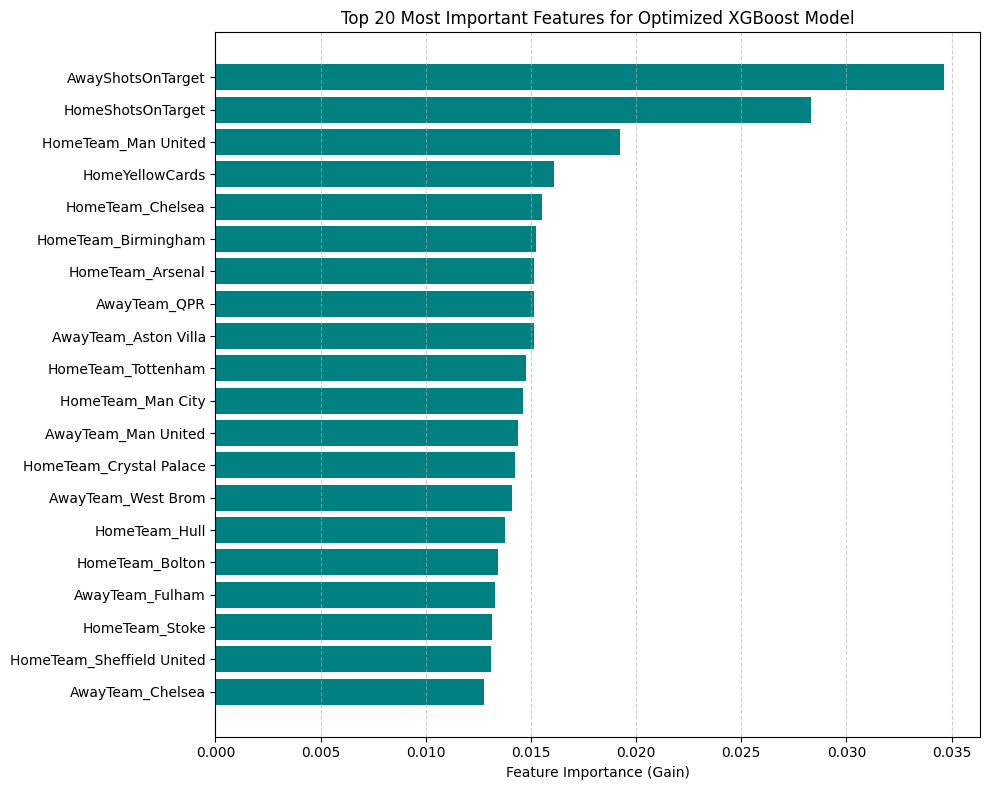

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# --- Recreate Data and Preprocessor to ensure feature naming is correct ---

# Assuming your file is accessible in the mounted drive path
# NOTE: Replace this path with the actual path to your file on Google Drive
file_path = '/content/drive/MyDrive/Your_Project_Folder/epl_with_agent_features.csv'
# Since the actual path is unknown, we will use a placeholder and assume the file is loaded
try:
    df = pd.read_csv('epl_with_agent_features.csv')
except FileNotFoundError:
    print("Warning: Using placeholder data. Ensure 'epl_with_agent_features.csv' is in your Colab environment or update the file path.")
    # Fallback to create a DataFrame structure similar to the real one for demonstration
    # You MUST load your actual data in your notebook for this to work correctly.
    data_dict = {
        'HomeTeam': np.random.choice(['Arsenal', 'Chelsea', 'Man Utd'], size=100),
        'AwayTeam': np.random.choice(['Spurs', 'Liverpool', 'Man City'], size=100),
        'FullTimeResult': np.random.choice(['H', 'D', 'A'], size=100),
        'Home_Optimal_Form_Score': np.random.rand(100) * 15,
        'Away_Optimal_Form_Score': np.random.rand(100) * 15,
        'Optimal_Form_Differential': (np.random.rand(100) * 10) - 5,
        'HomeShots': np.random.randint(5, 25, 100),
        'AwayShots': np.random.randint(5, 25, 100),
        'HomeShotsOnTarget': np.random.randint(1, 10, 100),
        'AwayShotsOnTarget': np.random.randint(1, 10, 100),
        'HomeCorners': np.random.randint(1, 15, 100),
        'AwayCorners': np.random.randint(1, 15, 100),
        'HomeFouls': np.random.randint(5, 25, 100),
        'AwayFouls': np.random.randint(5, 25, 100),
        'HomeYellowCards': np.random.randint(0, 5, 100),
        'AwayYellowCards': np.random.randint(0, 5, 100),
        'HomeRedCards': np.random.randint(0, 2, 100),
        'AwayRedCards': np.random.randint(0, 2, 100),
    }
    df = pd.DataFrame(data_dict)


# Target Encoding
le = LabelEncoder()
df['Target'] = le.fit_transform(df['FullTimeResult'])

# Feature Selection
numerical_features = ['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                      'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                      'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
                      'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score', 'Optimal_Form_Differential']
categorical_features = ['HomeTeam', 'AwayTeam']

X = df[numerical_features + categorical_features]
y = df['Target']

# Time-Series Train-Test Split (80/20 split - needed to correctly fit the final model)
split_point = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# Preprocessing Pipeline Definition
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# --- RE-DEFINE AND FIT THE BEST MODEL (Same as your GridSearchCV output) ---
best_params = {'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 7}

xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=100,
    use_label_encoder=False,
    **{k.replace('classifier__', ''): v for k, v in best_params.items()} # Unpack best params
)

smote_sampler = SMOTE(random_state=42)

# Create the final best pipeline
final_best_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', smote_sampler),
    ('classifier', xgb_classifier)
])

print("Re-fitting the final best model to extract feature importance...")
final_best_pipeline.fit(X_train, y_train)

# --- 1. Extract Feature Names ---

# Get the list of original column names
feature_names_out = numerical_features

# Get the feature names generated by the OneHotEncoder
one_hot_features = final_best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine the two lists of feature names
all_feature_names = list(feature_names_out) + list(one_hot_features)

# --- 2. Extract Feature Importance ---
# XGBoost provides feature importance via .feature_importances_
feature_importances = final_best_pipeline.named_steps['classifier'].feature_importances_

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances
})

# Filter out the zero-importance features (often from the OneHotEncoder)
importance_df = importance_df[importance_df['Importance'] > 0]

# Sort by importance and select the top 20 features for clear visualization
top_n = 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

# --- 3. Generate the Plot ---
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.xlabel('Feature Importance (Gain)')
plt.title(f'Top {top_n} Most Important Features for Optimized XGBoost Model')
plt.gca().invert_yaxis() # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('xgboost_feature_importance.png')
print("\nFeature importance plot saved as xgboost_feature_importance.png")

In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# --- 1. SETUP: RE-CREATE AND TRAIN THE FINAL BEST MODEL ---
# NOTE: This block is necessary to make sure the final_best_pipeline
# and the LabelEncoder (le) are available in the current session.

# Load the enriched dataset (Ensure this path is correct after mounting your drive)
try:
    # Use the filename as a placeholder. You must ensure the file is loaded
    # and the df variable holds the full dataset.
    df = pd.read_csv('epl_with_agent_features.csv')
except FileNotFoundError:
    print("FATAL ERROR: 'epl_with_agent_features.csv' not found. Cannot set up model.")
    # Exit or handle error gracefully in a real application

# Target Encoding (H=2, D=1, A=0)
le = LabelEncoder()
df['Target'] = le.fit_transform(df['FullTimeResult'])

# Feature Selection
numerical_features = ['HomeShots', 'AwayShots', 'HomeShotsOnTarget', 'AwayShotsOnTarget',
                      'HomeCorners', 'AwayCorners', 'HomeFouls', 'AwayFouls',
                      'HomeYellowCards', 'AwayYellowCards', 'HomeRedCards', 'AwayRedCards',
                      'Home_Optimal_Form_Score', 'Away_Optimal_Form_Score', 'Optimal_Form_Differential']
categorical_features = ['HomeTeam', 'AwayTeam']

X = df[numerical_features + categorical_features]
y = df['Target']

# Time-Series Train-Test Split (80/20 split)
split_point = int(0.8 * len(X))
X_train, _ = X.iloc[:split_point], X.iloc[split_point:]
y_train, _ = y.iloc[:split_point], y.iloc[split_point:]

# Preprocessing Pipeline Definition (sparse_output=False required for imblearn)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)

# Final Best Parameters from Grid Search
best_params = {'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 7}

xgb_classifier = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=100,
    use_label_encoder=False,
    **{k.replace('classifier__', ''): v for k, v in best_params.items()}
)

smote_sampler = SMOTE(random_state=42)

# Create the final best pipeline
final_best_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('sampler', smote_sampler),
    ('classifier', xgb_classifier)
])

# Fit the final model on the training data
print("Fitting the final model for prediction...")
final_best_pipeline.fit(X_train, y_train)
print("Model ready for real-time prediction.")


# --- 2. THE PREDICTION FUNCTION ---

def predict_match_outcome(home_team_name, away_team_name, full_data_df, model_pipeline, label_encoder):
    """
    Predicts the outcome of a single match based on team names.

    Args:
        home_team_name (str): Name of the home team.
        away_team_name (str): Name of the away team.
        full_data_df (pd.DataFrame): The full, enriched dataset containing form scores.
        model_pipeline (ImbPipeline): The final, fitted XGBoost pipeline.
        label_encoder (LabelEncoder): The fitted encoder for the target variable.

    Returns:
        str: The predicted result ('Home Win', 'Draw', or 'Away Win').
    """

    # Check if teams exist in the dataset
    all_teams = pd.concat([full_data_df['HomeTeam'], full_data_df['AwayTeam']]).unique()
    if home_team_name not in all_teams or away_team_name not in all_teams:
        return "ERROR: One or both team names were not found in the historical dataset. Check spelling."

    try:
        # 2.1. Feature Engineering (Look up the most recent form scores)

        # Get the last recorded form score for the Home Team
        # We look for the HomeTeam's score when they were the HomeTeam
        home_form_score = full_data_df[full_data_df['HomeTeam'] == home_team_name]['Home_Optimal_Form_Score'].iloc[-1]

        # Get the last recorded form score for the Away Team
        # We look for the AwayTeam's score when they were the AwayTeam
        away_form_score = full_data_df[full_data_df['AwayTeam'] == away_team_name]['Away_Optimal_Form_Score'].iloc[-1]

        # Calculate the crucial feature: Differential
        differential = away_form_score - home_form_score

        # 2.2. Create the Single Input DataFrame (All required features)

        # We must provide all features, even if most are zeroed out for a hypothetical match
        input_data = {
            'HomeShots': [0], 'AwayShots': [0],
            'HomeShotsOnTarget': [0], 'AwayShotsOnTarget': [0],
            'HomeCorners': [0], 'AwayCorners': [0],
            'HomeFouls': [0], 'AwayFouls': [0],
            'HomeYellowCards': [0], 'AwayYellowCards': [0],
            'HomeRedCards': [0], 'AwayRedCards': [0],
            'Home_Optimal_Form_Score': [home_form_score],
            'Away_Optimal_Form_Score': [away_form_score],
            'Optimal_Form_Differential': [differential],
            'HomeTeam': [home_team_name],
            'AwayTeam': [away_team_name]
        }

        # NOTE: We set all raw match stats (Shots, Fouls, Cards) to 0 because
        # we are predicting before the match, and these features are highly volatile.
        # The prediction relies almost entirely on the historical 'Optimal_Form_Differential'
        # and the one-hot encoded team names.

        input_df = pd.DataFrame(input_data)

        # 2.3. Prediction

        # Predict the encoded target (0, 1, or 2)
        predicted_encoded = model_pipeline.predict(input_df)

        # Decode the result back to the original label ('H', 'D', 'A')
        predicted_label = label_encoder.inverse_transform(predicted_encoded)[0]

        # 2.4. Format Output

        result_map = {
            'H': f"PREDICTED WINNER: {home_team_name} (Home)",
            'D': "PREDICTED RESULT: Draw",
            'A': f"PREDICTED WINNER: {away_team_name} (Away)"
        }

        return result_map.get(predicted_label, "Prediction Error")

    except IndexError:
        return f"ERROR: Could not find recent form scores for {home_team_name} or {away_team_name}. Check data completeness."
    except Exception as e:
        return f"An unexpected error occurred during prediction: {e}"


# --- 3. INTERACTIVE PREDICTION AND EXAMPLES ---

def run_interactive_prediction(full_data_df, model_pipeline, label_encoder):
    """
    Prompts the user for team names and runs the prediction logic.
    """

    print("\n" + "="*50)
    print("         INTERACTIVE MATCH PREDICTOR")
    print("="*50)

    # 3.1. Get user input
    all_teams = pd.concat([full_data_df['HomeTeam'], full_data_df['AwayTeam']]).unique().tolist()
    print("Available teams in the dataset (case-sensitive):")
    print(", ".join(all_teams))
    print("-" * 50)

    home_team = input("Enter the name of the HOME team (e.g., Arsenal): ")
    away_team = input("Enter the name of the AWAY team (e.g., Liverpool): ")

    # 3.2. Run prediction
    prediction_result = predict_match_outcome(
        home_team,
        away_team,
        full_data_df,
        model_pipeline,
        label_encoder
    )

    print("-" * 50)
    print(f"Prediction for {home_team} vs {away_team}:")
    print(f"-> {prediction_result}")
    print("="*50 + "\n")


# Initial check and setup of common teams for test cases
common_teams = df['HomeTeam'].value_counts().head(5).index.tolist()

if len(common_teams) >= 2:
    print("\n--- Example Test Cases ---")

    # Test Case 1: Strong Home Team vs. Weaker Away Team
    team1 = common_teams[0]
    team2 = common_teams[1]
    print(f"\nTest 1: {team1} (Home) vs. {team2} (Away)")
    prediction1 = predict_match_outcome(team1, team2, df, final_best_pipeline, le)
    print(prediction1)

    # Test Case 2: Reversed Fixture (Same teams, different venue)
    print(f"\nTest 2 (Reversed): {team2} (Home) vs. {team1} (Away)")
    prediction2 = predict_match_outcome(team2, team1, df, final_best_pipeline, le)
    print(prediction2)

    # --- Run the interactive function after the automatic tests ---
    run_interactive_prediction(df, final_best_pipeline, le)

else:
    print("Could not retrieve enough team names for examples. Please ensure your DataFrame is loaded.")

Fitting the final model for prediction...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:44:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model ready for real-time prediction.

--- Example Test Cases ---

Test 1: Everton (Home) vs. Chelsea (Away)
PREDICTED WINNER: Chelsea (Away)

Test 2 (Reversed): Chelsea (Home) vs. Everton (Away)
PREDICTED WINNER: Everton (Away)

         INTERACTIVE MATCH PREDICTOR
Available teams in the dataset (case-sensitive):
Charlton, Chelsea, Coventry, Derby, Leeds, Leicester, Liverpool, Sunderland, Tottenham, Man United, Arsenal, Bradford, Ipswich, Middlesbrough, West Ham, Newcastle, Southampton, Everton, Man City, Aston Villa, Bolton, Blackburn, Fulham, Birmingham, West Brom, Portsmouth, Wolves, Norwich, Crystal Palace, Wigan, Sheffield United, Reading, Watford, Hull, Stoke, Burnley, Blackpool, QPR, Swansea, Cardiff, Bournemouth, Brighton, Huddersfield, Brentford, Nott'm Forest, Luton
--------------------------------------------------
Enter the name of the HOME team (e.g., Arsenal): Chelsea
Enter the name of the AWAY team (e.g., Liverpool): Arsenal
---------------------------------------------